## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
!gdown --id 1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K

Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints-2021-05-14_08_16.json
83.4MB [00:00, 179MB/s]


In [3]:
# Opening JSON file 
f = open('/content/complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 

# returns JSON object as  
# a dictionary 


## Data preparation

In [4]:
data = json.load(f)


In [5]:
df = pd.json_normalize(data)

In [6]:
df.shape

(78313, 22)

In [7]:
data

[{'_id': '3211475',
  '_index': 'complaint-public-v2',
  '_score': 0.0,
  '_source': {'company': 'JPMORGAN CHASE & CO.',
   'company_public_response': None,
   'company_response': 'Closed with explanation',
   'complaint_id': '3211475',
   'complaint_what_happened': '',
   'consumer_consent_provided': 'Consent not provided',
   'consumer_disputed': 'N/A',
   'date_received': '2019-04-13T12:00:00-05:00',
   'date_sent_to_company': '2019-04-13T12:00:00-05:00',
   'issue': 'Attempts to collect debt not owed',
   'product': 'Debt collection',
   'state': 'CA',
   'sub_issue': 'Debt is not yours',
   'sub_product': 'Credit card debt',
   'submitted_via': 'Web',
   'tags': None,
   'timely': 'Yes',
   'zip_code': '90301'},
  '_type': 'complaint'},
 {'_id': '3229299',
  '_index': 'complaint-public-v2',
  '_score': 0.0,
  '_source': {'company': 'JPMORGAN CHASE & CO.',
   'company_public_response': None,
   'company_response': 'Closed with explanation',
   'complaint_id': '3229299',
   'complai

In [8]:
# Inspect the dataframe to understand the given data.
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [9]:
#print the column names
for col in df.columns:
  print(col)


_index
_type
_id
_score
_source.tags
_source.zip_code
_source.complaint_id
_source.issue
_source.date_received
_source.state
_source.consumer_disputed
_source.product
_source.company_response
_source.company
_source.submitted_via
_source.date_sent_to_company
_source.company_public_response
_source.sub_product
_source.timely
_source.complaint_what_happened
_source.sub_issue
_source.consumer_consent_provided


In [10]:
#Assign new column names
df.rename(columns ={'_index': 'index', '_type': 'type', '_id': 'id', '_score': 'score', '_source.tags': 'source_tags', 
                    '_source.zip_code': 'source_zip_code', '_source.complaint_id': 'source_complaint_id',
                    '_source.complaint_id': 'source_complaint_id', '_source.issue': 'source_issue',
                    '_source.date_received': 'source_date_received', '_source.state': 'source_state',
                    '_source.consumer_disputed': 'source_consumer_disputed', '_source.product': 'source_product',
                    '_source.company_response': 'source_company_response', '_source.company': 'source_company',
                    '_source.submitted_via': 'source_submitted_via', '_source.date_sent_to_company': 'source_date_sent_to_company',
                    '_source.company_public_response': 'source_company_public_response', '_source.sub_product': 'source_sub_product',
                    '_source.timely': 'source_timely', '_source.complaint_what_happened': 'source_complaint_what_happened',
                    '_source.sub_issue': 'source_sub_issue', '_source.consumer_consent_provided': 'source_consumer_consent_provided'}, inplace = True)

In [11]:
#Assign nan in place of blanks in the complaints column
df[df['source_complaint_what_happened']== ''] = np.nan 

In [12]:
#Remove all rows where complaints column is nan
df = df[df['source_complaint_what_happened'].notnull()]

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text = text.lower()
  pattern = re.compile('[\(\[].*?[\)\]]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[^\w\s]')
  text = re.sub(pattern, '', text)
  pattern = re.compile('[0-9]')
  text = re.sub(pattern, '', text)
  return text



In [14]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [15]:
#Write your function to Lemmatize the texts
def lemmatizer(text):      
    text = clean_text(text)  
    sent = [wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
    return " ".join(sent)

In [16]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
df_clean['complaints'] = df['source_complaint_what_happened'].apply(lambda x: clean_text(x))
df_clean['lemmatized_complaints'] = df['source_complaint_what_happened'].apply(lambda x: lemmatizer(x))
########above step is time consuming



In [17]:
df_clean.to_csv('df_clean.csv', index=False)

In [18]:
#Write your function to extract the POS tags 
def pos_tag(text):
  doc = nlp(text)
  result = []
  for token in doc:
    if token.pos_ == 'NOUN':
      output = result.append(token.text)
      
  return ' '.join(result)


In [19]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_POS_removed'] = df_clean['complaints'].apply(lambda x: pos_tag(x))

In [26]:
df_clean.to_csv('df_clean_2.csv', index=False)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




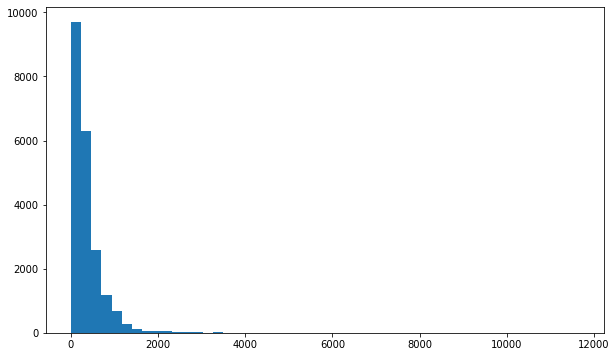

In [27]:
# Write your code here to visualise the data according to the 'Complaint' character length
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

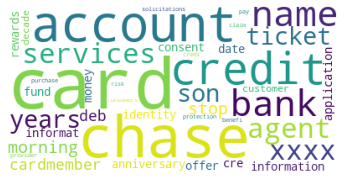

In [21]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stoplist = set(stopwords.words("english"))


wordcloud = WordCloud(stopwords=stoplist,max_words=40, background_color='white').generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();


In [22]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [28]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['Complaint_clean'], 30)

In [29]:
#Print the top 10 words in the unigram frequency
df_unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
df_unigram.iloc[:10,:]

,unigram,count
0,account,40727
1,chase,36556
2,credit,31255
3,card,26117
4,bank,14401
5,payment,13690
6,xxxx,13423
7,money,11808
8,time,11695
9,information,9511


In [30]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['Complaint_clean'], 30)

In [31]:
#Print the top 10 words in the bigram frequency
df_bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
df_bigram.iloc[:10,:]

,bigram,count
0,credit card,10532
1,credit report,3177
2,customer service,2790
3,chase credit,2541
4,account account,2327
5,chase account,2226
6,checking account,2145
7,account chase,2037
8,bank account,1869
9,credit cards,1850


In [32]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['complaints'], 30)

In [33]:
#Print the top 10 words in the trigram frequency
df_trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
df_trigram.iloc[:10,:]

,trigram,count
0,xxxx xxxx xxxx,37868
1,jp morgan chase,2284
2,chase credit card,1779
3,xxxx xxxx chase,1644
4,xxxxxxxx xxxx xxxx,1572
5,xxxx xxxx xxxxxxxx,1263
6,chase xxxx xxxx,1111
7,chase bank xxxx,1060
8,xxxx xxxxxxxx xxxx,954
9,account xxxx xxxx,908


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [34]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [35]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,ticket offer ticket rewards card information ...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase years banking merchan...,pay risk consumers chase years banking merchan...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit credit cards chase freedom xxxx problem...,credit credit cards chase freedom problems ba...


In [31]:
df.shape

(21072, 22)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [36]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
# Transform word vector in tfidf vector
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)




In [37]:
X = vectorizer.fit_transform(df_clean['Complaint_clean'].tolist())

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [38]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm  = vectorizer.fit_transform(df_clean.Complaint_clean) 
##tfidf = vectorizer.fit_transform(df_clean.Complaint_clean) 


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [42]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [43]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components = 5, random_state = 40)

In [44]:
W = nmf_model.fit_transform(dtm)
H =nmf_model.components_

In [45]:
nmf_model.fit(dtm)


NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=40, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [46]:
len(vectorizer.get_feature_names())



7355

In [47]:
W1 = pd.DataFrame(W, columns=["Topic" + str(i) for i in range(nmf_model.n_components)],
                 index=[f'Doc {i}' for i in range(X.shape[0])])

In [48]:

W1['max_topic'] = W1.apply(lambda x: x.idxmax(), axis=1)
W1

,Topic0,Topic1,Topic2,Topic3,Topic4,max_topic
Doc 0,0.023608,0.015176,0.014952,0.004673,0.009699,Topic0
Doc 1,0.009071,0.001064,0.003089,0.020453,0.003307,Topic3
Doc 2,0.000000,0.038306,0.000000,0.025018,0.000000,Topic1
Doc 3,0.014791,0.057050,0.009737,0.016730,0.000000,Topic1
Doc 4,0.067322,0.000000,0.001854,0.000000,0.000000,Topic0
...,...,...,...,...,...,...
Doc 21067,0.003258,0.035431,0.000000,0.049830,0.022108,Topic3
Doc 21068,0.010787,0.000000,0.008460,0.034459,0.000491,Topic3
Doc 21069,0.012897,0.012630,0.005830,0.018290,0.000376,Topic3
Doc 21070,0.000000,0.024994,0.000000,0.049996,0.119803,Topic4


In [49]:
W.shape

(21072, 5)

In [50]:
H.shape

(5, 7355)

In [51]:
H

array([[0.00000000e+00, 0.00000000e+00, 3.09042675e-04, ...,
        0.00000000e+00, 4.34951999e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.02163786e-03, 0.00000000e+00, 0.00000000e+00],
       [1.01798019e-03, 1.18194018e-03, 1.71734571e-03, ...,
        2.11802415e-03, 3.87532124e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.97201282e-04, 3.09842720e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.37248323e-03, 4.14891391e-03]])

In [52]:
#Print the Top15 words for each of the topics


words = np.array(vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,bank,funds,chase,branch,checking,deposit,accounts,number,days,business,checks,fraud
Topic 2,credit,report,inquiry,inquiries,card,score,cards,accounts,account,debt,information,bureaus,limit,reports,reporting
Topic 3,loan,mortgage,home,modification,chase,property,payments,years,rate,house,letter,foreclosure,time,documents,sale
Topic 4,card,chase,charges,charge,credit,dispute,fraud,merchant,company,fee,transaction,purchase,phone,number,service
Topic 5,payment,payments,balance,month,fees,fee,statement,date,time,auto,days,account,chase,error,months


***We can see here that 2nd topic is more about credit card, 3rd is more about loan /mortgage , topic 4 is about fraud/dispute while 5th is related to bank services. So first is mixture and it can be added in others category***

In [46]:
df_clean.shape

(21072, 4)

In [53]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
#colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df_clean.Complaint_clean))]
df_doc_topic = pd.DataFrame(np.round(W, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic

In [54]:
df_doc_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.02,0.02,0.01,0.00,0.01,0
Doc1,0.01,0.00,0.00,0.02,0.00,3
Doc2,0.00,0.04,0.00,0.03,0.00,1
Doc3,0.01,0.06,0.01,0.02,0.00,1
Doc4,0.07,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...
Doc21067,0.00,0.04,0.00,0.05,0.02,3
Doc21068,0.01,0.00,0.01,0.03,0.00,3
Doc21069,0.01,0.01,0.01,0.02,0.00,3
Doc21070,0.00,0.02,0.00,0.05,0.12,4


In [91]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = significant_topic

In [92]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...,0
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,3
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...,1
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,ticket offer ticket rewards card information ...,1
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitations credi...,chase card customer decade solicitations credi...,3
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...,3
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumers chase years banking merchan...,pay risk consumers chase years banking merchan...,3
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit credit cards chase freedom xxxx problem...,credit credit cards chase freedom problems ba...,4


Here also sentences are almost matching with the labels which were comming through Top Words counts

In [93]:

#Print the first 5 Complaint for each of the Topics
d = df_clean.groupby('Topic').head(5)
d.sort_values('Topic')

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...,0
24,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account,account,0
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,0
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...,0
27,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,account code xxxxxxxx terms account deposit bo...,account code terms account deposit bonus days...,0
15,can you please remove inquiry,please remove inquiry,inquiry,inquiry,1
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...,1
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card data credit report company i...,chase credit card data credit report company i...,1
26,i have reached out to xxxx several times in at...,reached xxxx several time attempt fraudulent i...,times attempt inquiry creditor inquiry report ...,times attempt inquiry creditor inquiry report ...,1
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,ticket offer ticket rewards card information ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [76]:
#Assign the best topic to each of the cmplaints in Topic Column

topic_mapping = {
    'Topic 1': 'Others',
    'Topic 2': 'Credit Card',
    'Topic 3': 'Mortgage /Loans',
    'Topic 4': 'Theft/Dispute reporting',
    'Topic 5': 'Bank account services'
    
}

In [94]:

# Recall the document-topic matrix, W

W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.023608,0.015176,0.014952,0.004673,0.009699,Others
1,0.009071,0.001064,0.003089,0.020453,0.003307,Theft/Dispute reporting
2,0.000000,0.038306,0.000000,0.025018,0.000000,Credit Card
3,0.014791,0.057050,0.009737,0.016730,0.000000,Credit Card
4,0.067322,0.000000,0.001854,0.000000,0.000000,Others
5,0.000000,0.049272,0.000000,0.000000,0.000000,Credit Card
6,0.067742,0.000000,0.006087,0.010121,0.009265,Others
7,0.003153,0.000000,0.031593,0.008906,0.057467,Bank account services
8,0.028553,0.000000,0.018880,0.040731,0.004707,Theft/Dispute reporting
9,0.000000,0.111597,0.000000,0.047755,0.000000,Credit Card


In [108]:
W['max_topic'].value_counts()

Theft/Dispute reporting    5949
Others                     5645
Mortgage /Loans            3589
Credit Card                3523
Bank account services      2366
Name: max_topic, dtype: int64

**Here maximum statements are falling under Theft/Dispute Reporting categories**

In [85]:
##To visualise the data lets create the new dataframe(Since we need integer only later on for Supervised learning)
visual_df = df_clean

In [97]:

visual_df['Topic'] = W['max_topic']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [98]:
visual_df

,complaints,lemmatized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name stop bank cardmember services deb...,morning name stop bank cardmember services deb...,Theft/Dispute reporting
2,i upgraded my xxxx xxxx card in xxxx and was t...,upgraded xxxx xxxx card xxxx told agent upgrad...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Credit Card
10,chase card was reported on xxxx however fraudu...,chase card reported xxxx however fraudulent ap...,card application identity consent services cre...,card application identity consent services cre...,Others
11,on xxxx while trying to book a xxxx xxxx tic...,xxxx trying book xxxx xxxx ticket came across ...,xxxx ticket offer ticket rewards card informat...,ticket offer ticket rewards card information ...,Credit Card
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son chase account fund bank account money son ...,son chase account fund bank account money son ...,Theft/Dispute reporting
15,can you please remove inquiry,please remove inquiry,inquiry,inquiry,Others
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,Others
20,during the summer months i experience a declin...,summer month experience decline income due emp...,summer months decline income employment month ...,summer months decline income employment month ...,Theft/Dispute reporting
21,on xxxx xxxx i made a payment to an online re...,xxxx xxxx made payment online retailer using c...,payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,Theft/Dispute reporting
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card data credit report company i...,chase credit card data credit report company i...,Mortgage /Loans


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [82]:
df_clean.dtypes

complaints               object
lemmatized_complaints    object
complaint_POS_removed    object
Complaint_clean          object
Topic                    object
dtype: object

In [99]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['Complaint_clean','Topic']]


#training_data = training_data[training_data['Complaint_clean'].notnull()]

In [100]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [101]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
import pickle
#Write your code to get the Vector count
vectorizer = CountVectorizer()
vector_count = vectorizer.fit_transform(training_data.Complaint_clean)
#Write your code here to transform the word vector to tf-idf
vectorizer = TfidfVectorizer(min_df=2, max_df=.95, use_idf=True )
tfidf_transform = TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(vector_count) 


# Save tfidf 
#pickel.dump(tfidf_transform, open("tfidf.pkl","wb"))
y= training_data.Topic
#Create the train & test data using the train_test_split on the tf-idf & topics
train_x, test_x, train_y, test_y =train_test_split(X_train_tfidf, y, test_size=0.25, random_state=42)

You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [105]:
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)
result_bayes = pd.DataFrame( {'true_labels': y_test,'predicted_labels': predicted})

for predicted_item, result in zip(predicted, y_test):
    #print(target_names[predicted_item], ' - ', y_test)
    print(predicted_item, result)

Streaming output truncated to the last 5000 lines.
3 3
2 2
0 0
4 4
3 3
1 1
3 3
0 0
0 0
2 2
2 2
3 3
1 1
1 1
1 1
2 2
3 3
0 0
3 3
3 3
0 0
3 4
0 0
2 2
2 2
3 3
0 0
2 2
3 2
3 3
0 0
3 3
0 0
2 2
2 2
3 3
3 3
2 2
0 0
1 1
3 3
2 2
3 4
0 3
3 3
3 4
0 0
1 1
3 3
1 2
0 0
3 1
3 3
0 0
3 3
0 0
3 3
0 1
0 0
3 3
0 0
3 3
2 2
3 1
0 0
1 4
3 1
1 1
3 3
0 0
3 3
0 0
3 3
3 3
3 4
0 3
0 0
1 1
0 0
2 4
1 1
2 4
0 0
0 0
0 0
3 3
2 2
0 0
3 4
0 0
3 3
0 1
1 0
0 0
0 0
3 3
2 2
0 0
1 1
3 3
1 1
1 1
0 0
1 4
3 1
2 4
0 0
0 3
0 0
1 1
2 2
0 0
0 0
0 4
0 0
3 1
3 3
3 3
0 4
2 2
3 3
0 0
2 2
2 2
0 0
0 0
1 1
0 0
1 1
0 0
3 3
3 1
1 1
0 0
0 0
0 0
1 1
0 0
0 0
3 3
2 2
2 2
0 0
3 3
2 2
0 0
0 0
1 1
0 0
3 1
0 0
1 1
2 2
1 1
0 0
3 3
0 0
0 1
3 3
0 3
3 3
0 0
1 4
0 4
2 0
3 3
1 1
2 2
1 3
2 2
0 1
3 4
0 0
1 1
2 2
3 3
0 0
3 3
0 0
4 4
0 0
0 0
3 3
2 2
3 3
2 2
0 0
0 1
0 0
2 2
3 3
0 0
0 0
0 0
0 0
0 0
1 1
2 3
0 0
3 3
3 3
2 2
3 3
4 4
0 0
3 3
0 0
3 3
2 2
0 0
3 4
3 3
1 1
0 0
2 4
1 1
0 0
3 3
0 0
3 0
0 0
3 4
3 0
0 3
1 1
3 3
2 2
1 1
3 3
0 0
3 3
0 4
0 0
2 2
1 1
2 2
0 0
1

**we can notice visually that most of the values are matching. Lets see the metrics and try to run other models to see the best model**

In [106]:
from sklearn import metrics
metrics.accuracy_score(y_test, predicted)

0.7613895216400911

In [107]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# Multinomial Naive Bayes
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score , classification_report

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size=0.25, random_state=42)




tree= DecisionTreeClassifier() # using the random state for reproducibility
forest= RandomForestClassifier()
logisitc = LogisticRegression()
NB = MultinomialNB()
#knn= KNeighborsClassifier()
#svm= SVC(random_state=24)
#xboost= XGBClassifier(random_state=24)

models= [NB, logisitc, forest, tree]


for model in models:
    model.fit(X_train, y_train) # fit the model
    y_pred= model.predict(X_test) # then predict on the test set
    accuracy= accuracy_score(y_test, y_pred) # this gives us how often the algorithm predicted correctly
    clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The accuracy of model {type(model).__name__} is {accuracy:.2f}")
    print(clf_report)
    print("\n")







The accuracy of model MultinomialNB is 0.76
              precision    recall  f1-score   support

           0       0.71      0.90      0.79      1568
           1       0.87      0.69      0.77       941
           2       0.84      0.85      0.85       863
           3       0.72      0.85      0.78      1378
           4       0.98      0.10      0.18       518

    accuracy                           0.76      5268
   macro avg       0.82      0.68      0.67      5268
weighted avg       0.79      0.76      0.73      5268





/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



The accuracy of model LogisticRegression is 0.95
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1568
           1       0.97      0.92      0.94       941
           2       0.95      0.95      0.95       863
           3       0.95      0.97      0.96      1378
           4       0.97      0.91      0.94       518

    accuracy                           0.95      5268
   macro avg       0.95      0.94      0.95      5268
weighted avg       0.95      0.95      0.95      5268



The accuracy of model RandomForestClassifier is 0.87
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1568
           1       0.89      0.84      0.86       941
           2       0.91      0.91      0.91       863
           3       0.84      0.89      0.86      1378
           4       0.94      0.60      0.73       518

    accuracy                           0.87      5268
   macro avg       0.88    

***we can see that Logistic regression is giving best accuracy here in terms of all materics so it would be recommoned to use the same***